<a href="https://colab.research.google.com/github/OBILISETTVYSHNAVI/music-genre-prediction/blob/main/music_genre_classification_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q librosa tensorflow scikit-learn matplotlib pydub streamlit pyngrok soundfile

# 🔑 Upload your Kaggle API key
from google.colab import files
files.upload()  # Upload kaggle.json here

# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# ✅ Download GTZAN dataset from working source
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
!unzip -q gtzan-dataset-music-genre-classification.zip

import os
DATA_DIR = "/content/Data/genres_original"
genres = sorted(os.listdir(DATA_DIR))
print(genres)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
 97% 1.18G/1.21G [00:11<00:00, 186MB/s]
100% 1.21G/1.21G [00:11<00:00, 110MB/s]
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [77]:
# ✅ Import libraries
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from tqdm import tqdm
import seaborn as sns

# ✅ Dataset path (upload to this location in Colab)
DATA_PATH = "/content/Data/genres_original"

# ✅ Parameters
SAMPLES_PER_TRACK = 660000
MAX_LEN = 130
N_MFCC = 40

# ✅ Feature extractor
def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, duration=30)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)
        if mfcc.shape[1] < MAX_LEN:
            mfcc = np.pad(mfcc, ((0, 0), (0, MAX_LEN - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :MAX_LEN]
        return mfcc
    except Exception as e:
        print(f"❌ Failed for {file_path}: {e}")
        return None

# ✅ Load data
X, y = [], []
genres = os.listdir(DATA_PATH)
for genre in genres:
    genre_path = os.path.join(DATA_PATH, genre)
    if not os.path.isdir(genre_path): continue
    for file in tqdm(os.listdir(genre_path), desc=f"Processing {genre}"):
        if file.endswith((".wav", ".mp3", ".mp4")):
            file_path = os.path.join(genre_path, file)
            mfcc = extract_features(file_path)
            if mfcc is not None:
                X.append(mfcc)
                y.append(genre)

# ✅ Preprocessing
X = np.array(X)[..., np.newaxis]
y = np.array(y)
encoder = LabelEncoder()
y_encoded = to_categorical(encoder.fit_transform(y))
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# ✅ CNN model definition
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(N_MFCC, MAX_LEN, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')
])

# ✅ Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

# ✅ Save model
model.save("genre_cnn.keras")
print("✅ Model saved as genre_cnn.keras")


Processing jazz:  63%|██████▎   | 63/100 [00:04<00:02, 15.42it/s]/tmp/ipython-input-77-1780648233.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, duration=30)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing jazz:  68%|██████▊   | 68/100 [00:05<00:02, 10.85it/s]

❌ Failed for /content/Data/genres_original/jazz/jazz.00054.wav: 


Processing reggae: 100%|██████████| 100/100 [00:04<00:00, 23.23it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.2379 - loss: 3.6156 - val_accuracy: 0.1600 - val_loss: 7.5550
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4816 - loss: 1.4449 - val_accuracy: 0.2000 - val_loss: 6.4831
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6989 - loss: 0.8688 - val_accuracy: 0.3500 - val_loss: 3.9097
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8341 - loss: 0.4988 - val_accuracy: 0.3850 - val_loss: 2.4532
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9201 - loss: 0.2722 - val_accuracy: 0.4850 - val_loss: 1.8399
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9205 - loss: 0.2129 - val_accuracy: 0.4850 - val_loss: 1.9395
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9754 - loss: 0.1025 - val_accuracy: 0.4950 - val_loss: 2.4616
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9727 - loss: 0.0914 - val_accuracy: 0.5050 - va

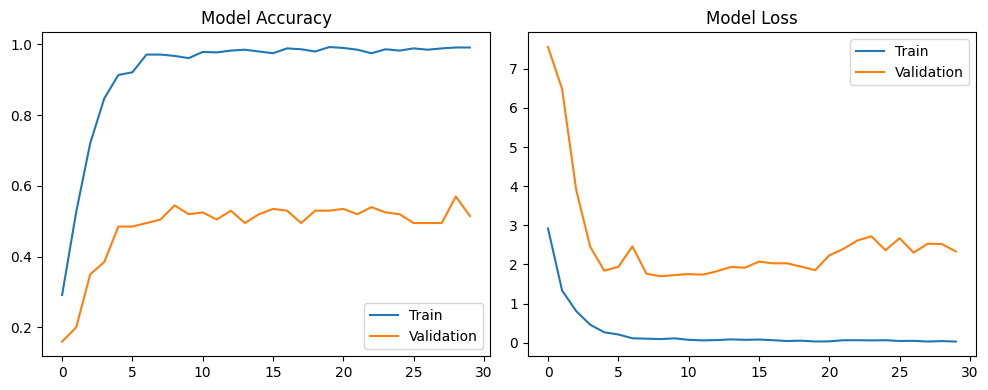

In [78]:
# ✅ Plot accuracy & loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Model Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Model Loss")
plt.legend()
plt.tight_layout()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


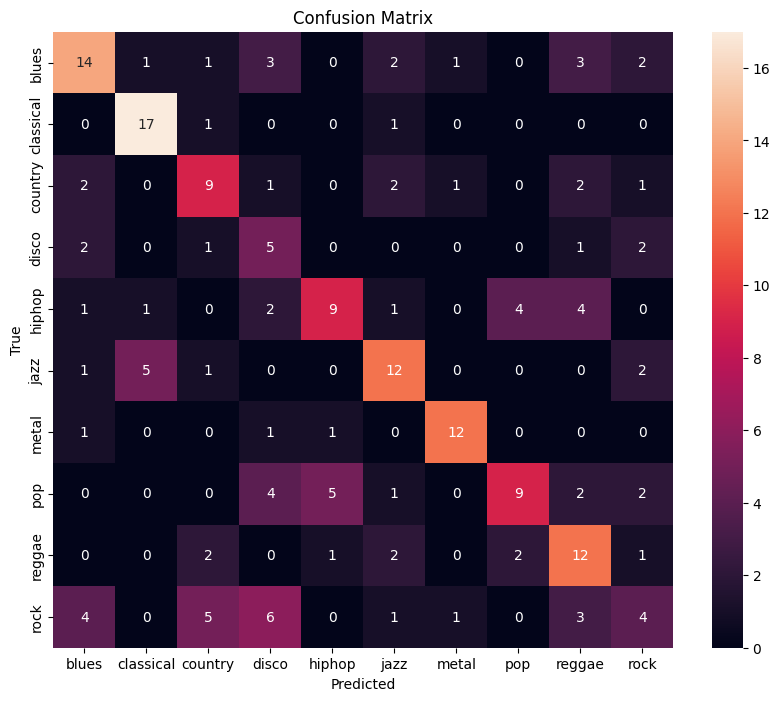

              precision    recall  f1-score   support

       blues       0.56      0.52      0.54        27
   classical       0.71      0.89      0.79        19
     country       0.45      0.50      0.47        18
       disco       0.23      0.45      0.30        11
      hiphop       0.56      0.41      0.47        22
        jazz       0.55      0.57      0.56        21
       metal       0.80      0.80      0.80        15
         pop       0.60      0.39      0.47        23
      reggae       0.44      0.60      0.51        20
        rock       0.29      0.17      0.21        24

    accuracy                           0.52       200
   macro avg       0.52      0.53      0.51       200
weighted avg       0.52      0.52      0.51       200



In [79]:
# ✅ Evaluate performance
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

In [80]:
# Save Streamlit app into app.py
app_code = """
import streamlit as st
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder

N_MFCC = 40
MAX_LEN = 130
MODEL_PATH = "genre_cnn.keras"
LABELS = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']

model = load_model(MODEL_PATH)
encoder = LabelEncoder()
encoder.fit(LABELS)

def extract_features(audio_path):
    try:
        audio, sr = librosa.load(audio_path, duration=30)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)
        if mfcc.shape[1] < MAX_LEN:
            mfcc = np.pad(mfcc, ((0, 0), (0, MAX_LEN - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :MAX_LEN]
        return mfcc[..., np.newaxis]
    except Exception as e:
        st.error(f"❌ Audio load failed: {e}")
        return None

st.set_page_config(page_title="🎵 Music Genre Classifier", layout="centered")
st.title("🎧 Music Genre Classifier")
st.write("Upload an audio file (`.mp3`, `.wav`, `.mp4`) to predict its genre.")

audio_file = st.file_uploader("Upload your audio file", type=["wav", "mp3", "mp4"])

if audio_file is not None:
    st.success(f"✅ File uploaded: {audio_file.name}")
    with open("temp_audio", "wb") as f:
        f.write(audio_file.read())

    features = extract_features("temp_audio")

    if features is not None:
        features = np.expand_dims(features, axis=0)
        prediction = model.predict(features)[0]
        predicted_index = np.argmax(prediction)
        predicted_label = encoder.inverse_transform([predicted_index])[0]
        confidence = prediction[predicted_index]

        st.markdown(f"### 🎶 Predicted Genre: **{predicted_label.upper()}**")
        st.markdown(f"### 🔮 Confidence: `{confidence:.2%}`")

        st.markdown("#### 🎯 Genre Prediction Probabilities")
        fig, ax = plt.subplots(figsize=(10, 4))
        sns.barplot(x=encoder.classes_, y=prediction, palette="viridis", ax=ax)
        plt.xticks(rotation=45)
        plt.ylabel("Probability")
        st.pyplot(fig)
"""

with open("app.py", "w") as f:
    f.write(app_code)


In [32]:
!pip install streamlit pyngrok pydub ffmpeg-python --quiet

In [81]:
!pip install streamlit pyngrok --quiet
!ngrok config add-authtoken 2yocmruTsVtX8DwYOPfPfda1ziJ_63UW4KK64WVMyAZcBVo4G

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [82]:
!pkill streamlit
!killall ngrok

In [83]:
!pkill streamlit  # kill stuck process
!streamlit run app.py &>/content/logs.txt &

import time
from pyngrok import ngrok
time.sleep(5)
public_url = ngrok.connect(addr="8501", proto="http")
print("🔗 App URL:", public_url)

🔗 App URL: NgrokTunnel: "https://edee-34-16-181-8.ngrok-free.app" -> "http://localhost:8501"
